### Pysal《官方文档》-可视化：
- splot空间数据的探索性分析：使用和可视化空间相关性 （主要是 单/双变量 的 全局/局部 莫兰指数）
> 内容：
1. 评估全局空间自相关（散点图+参考分布）
2. 组合可视化：Moran 局部散点图、LISA 聚类图和分级统计图
3. 双变量 Moran 统计量（全局/局部） 与其可视化

In [1]:
import matplotlib.pyplot as plt
from libpysal.weights.contiguity import Queen
from libpysal import examples
import numpy as np
import pandas as pd
import geopandas as gpd
import os
import splot

- 下载案例数据
  
用 libpysal.examples 下载 Guerry 项目案例的shp data 

In [2]:
guerry = examples.load_example('Guerry')
link_to_data = guerry.get_path('guerry.shp')
gdf = gpd.read_file(link_to_data)

- 对于此示例，我们将重点关注 Donatns（人均慈善捐款）变量。
- 计算连续权重 w。然后我们将权重转换为行标准化。

In [3]:
donations = gdf['Donatns'].values
w = Queen.from_dataframe(gdf, use_index=False)
w.transform = 'r'

- 评估全局空间自相关性
  
我们计算 Moran's I。针对连续属性的全局自相关性检验。

In [4]:
from esda.moran import Moran
moran = Moran(donations, w)
moran.I

0.3533613255848606

> 对统计量的值是根据完全空间随机性（CSR）的零假设下的参考分布来解释的。
- 可视化全局莫兰指数（Global Moran's I）分析结果，揭示变量的空间自相关性
- 莫兰散点图将观测值与其空间滞后值进行对比。横轴表示原始数据值（标准化后），纵轴表示对应的空间滞后值（即相邻区域的平均值，同样标准化）。根据数据点在四个象限中的分布情况，可以判断出不同的空间关联模式：高值聚集（HH）、低值聚集（LL）、低值被高值包围（LH）以及高值被低值包围（HL）。

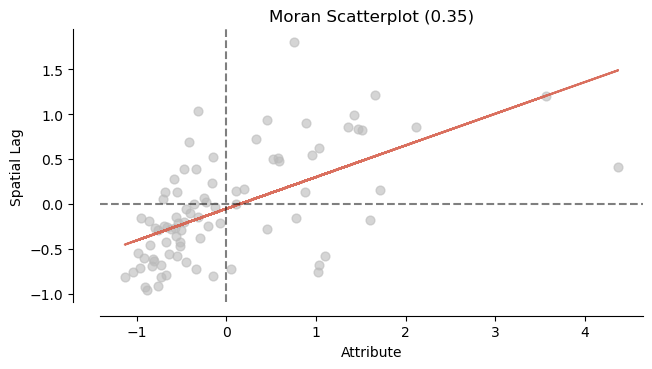

In [5]:
from splot.esda import moran_scatterplot
fig, ax = moran_scatterplot(moran, aspect_equal=True)
plt.show()

- splot.esda.plot_moran()用于绘制莫兰指数（Moran's I）相关的图形，包括莫兰指数散点图和蒙特卡洛参考分布图等

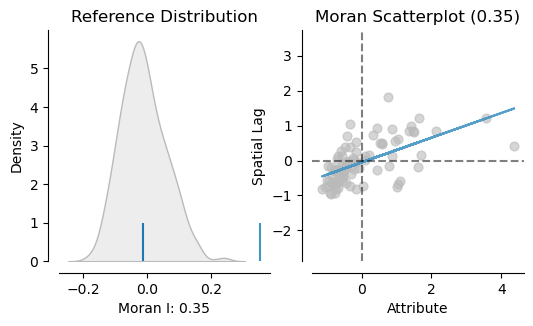

In [6]:
from splot.esda import plot_moran
plot_moran(moran, zstandard=True, figsize=(6,3),fitline_kwds=dict(color='#4395c3'))
plt.show()

> 使用 splot 可视化局部自相关 - 热点、冷点和空间异常值

除了可视化全局自相关统计数据外，splot 还提供了可视化局部自相关统计数据的选项。我们计算局部 Moran m。然后，我们在 Moran 散点图中绘制空间滞后和 Donatns 变量

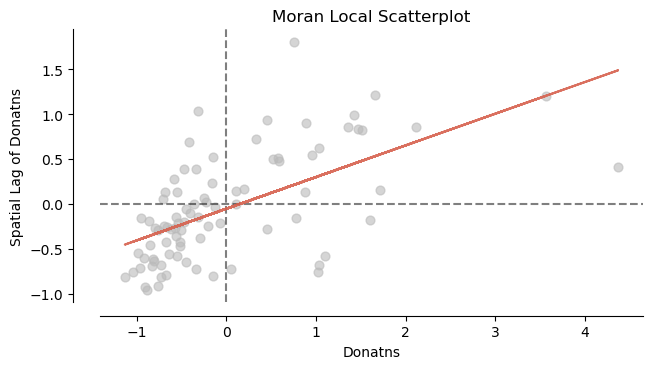

In [7]:
from splot.esda import moran_scatterplot
from esda.moran import Moran_Local
# calculate Moran_Local and plot
moran_loc = Moran_Local(donations, w)
fig, ax = moran_scatterplot(moran_loc, zstandard=True)
ax.set_xlabel('Donatns')
ax.set_ylabel('Spatial Lag of Donatns')
plt.show()

- 在 splot.esda 中的绘图函数api基本都有形参p
- 指定了在这个图中标记出那些在显著性水平（p=0.05）下显示出显著空间自相关的观测值。这有助于识别出具有特别高或低值的空间聚集区域

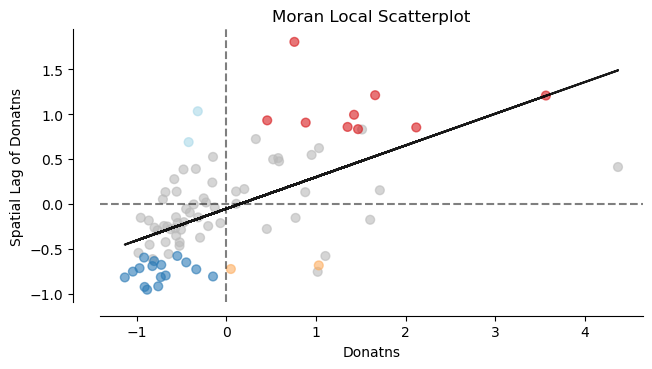

In [8]:
#标记异常值
fig, ax = moran_scatterplot(moran_loc, p=0.05)
ax.set_xlabel('Donatns')
ax.set_ylabel('Spatial Lag of Donatns')
plt.show()

> 我们可以将局部空间自相关的具体类型区分为高-高、低-低、高-低、低-高。其中右上象限显示 HH，左下象限显示 LL，左上象限显示 LH，左下象限显示 HL。

这些类型的局部空间自相关描述了特定多边形与其相邻多边形之间的相似性或不相似性。例如，左上象限表示低值的多边形被高值的多边形包围（LH）。右下象限显示高值的多边形被低值的邻居包围（HL）。这表明存在不相似值的关联。

- 现在让我们在地图上可视化我们发现的重要区域：

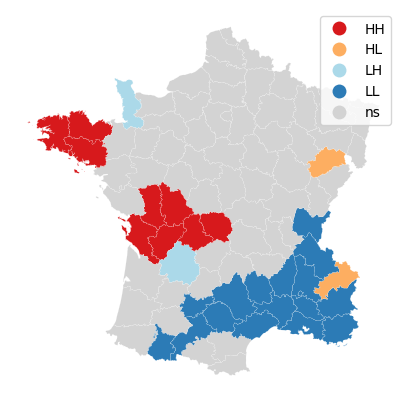

In [9]:
# splot.esda 的 lisa_cluster()函数 ： 可视化局部指标的空间关联（LISA）聚类，标识出高值聚集区（HH）、低值聚集区（LL）等
from splot.esda import lisa_cluster
lisa_cluster(moran_loc, gdf, p=0.05, figsize = (5,5))
plt.show()

> 组合可视化

通常，通过比较不同的可视化，更容易评估统计结果或解释这些结果。例如，我们在这里查看 Moran 散点图、LISA 聚类图和分级统计图的静态可视化。

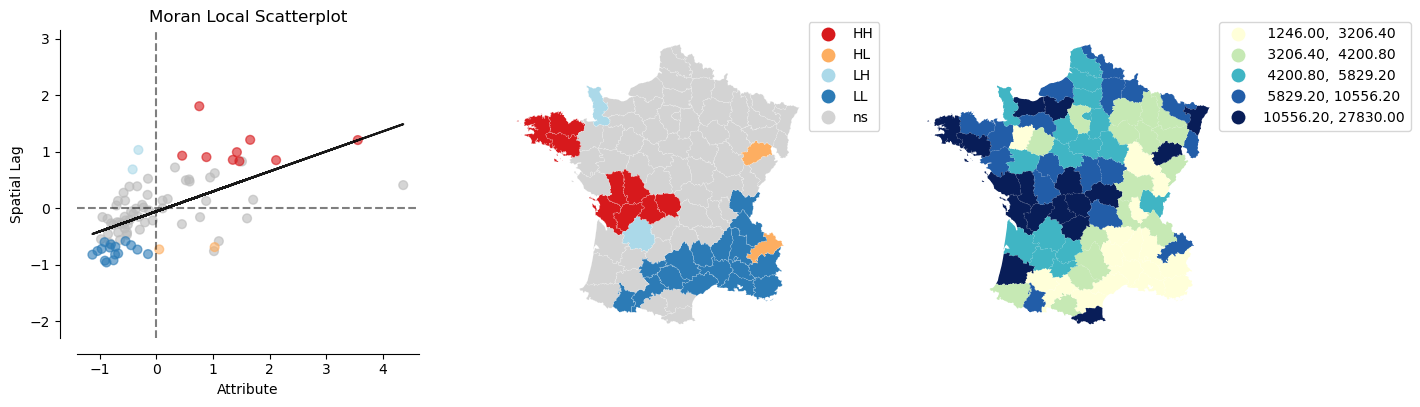

In [10]:
from splot.esda import plot_local_autocorrelation
plot_local_autocorrelation(moran_loc, gdf, 'Donatns')
plt.show()

- plot_local_autocorrelation()的quadrant参数 选择 lisa 空间关联聚类图的 屏蔽象限

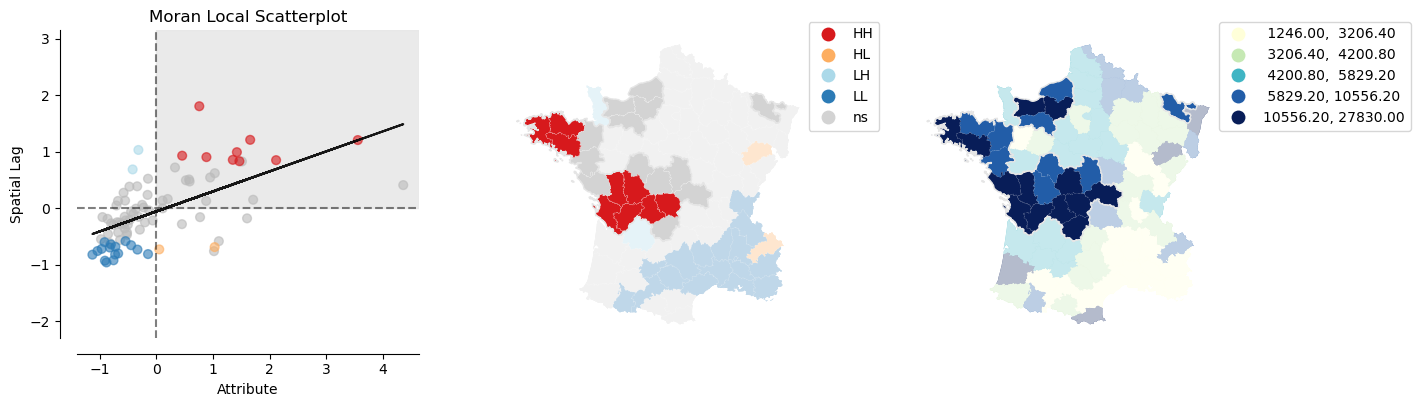

In [ ]:
plot_local_autocorrelation(moran_loc, gdf, 'Donatns', quadrant=1)
plt.show()

> 双变量的 Bivariate-Moran 统计
1. Moran_BV 类用于计算二变量的全局莫兰指数（Bivariate Moran's I），评估两个不同变量在空间上的相互依赖关系。它帮助我们理解一个变量的值是否与另一个变量在其邻近区域内的值存在关联。
2. Moran_Local_BV 类用于计算二变量的局部莫兰指数（Local Bivariate Moran's I），提供每个观测位置的空间自相关性的详细信息，特别是识别出具有显著空间聚集特性的位置。

In [ ]:
from esda.moran import Moran_BV, Moran_Local_BV

suicides = gdf['Suicids'].values
#moran = Moran(donations, w)
#定义双变量全局莫兰指数
moran_bv = Moran_BV(donations, suicides, w)

#moran_loc = Moran_Local(donations, w)
#定义双变量局部莫兰指数
moran_loc_bv = Moran_Local_BV(donations, suicides, w)

- 分别绘制 单/双 变量的 全局/局部 莫兰指数散点图

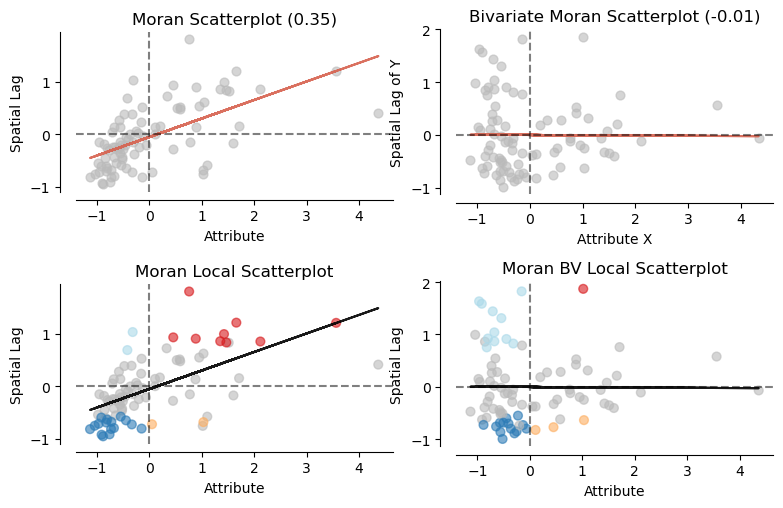

In [15]:
#开始绘图
fig, axs = plt.subplots(2, 2, figsize=(9,6),
                        subplot_kw={'aspect': 'equal'})
#单变量全局/局部莫兰指数 散点图
moran_scatterplot(moran, ax=axs[0,0])
moran_scatterplot(moran_loc, p=0.05, ax=axs[1,0])

#双变量全局/局部莫兰指数 散点图
moran_scatterplot(moran_bv, ax=axs[0,1])
moran_scatterplot(moran_loc_bv, p=0.05, ax=axs[1,1])

plt.show()

- 全局的双变量 Bivariate-Moran 统计描述一个变量与另一个变量的空间滞后之间的相关性。因此，我们必须谨慎解释我们的结果:
- Brivate-Moran 统计不描述同一位置的两个变量之间的固有相关性(注意：这里是否定！)。
- 它更多地提供了一种工具来表达具有特定属性的一个多边形与具有不同属性的相邻多边形的相关程度。

全局 Bivariate-Moran 参考分布和散点图的可视化来帮助解释结果：

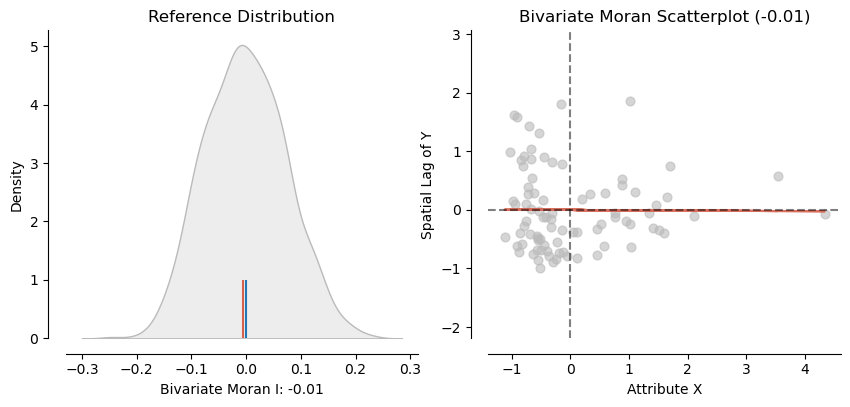

In [16]:
from splot.esda import plot_moran_bv_simulation, plot_moran_bv
plot_moran_bv(moran_bv)
plt.show()

- 局部双变量 Brivariate-Moran 统计：
1. 绘制双变量局部莫兰指数散点图

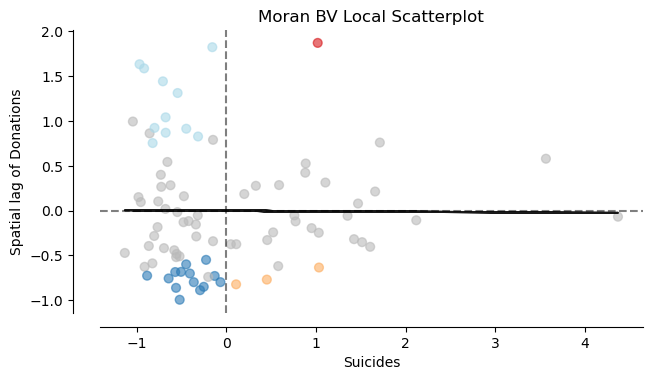

In [18]:
fig, ax = moran_scatterplot(moran_loc_bv, p=0.05)
ax.set_xlabel('Suicides')
ax.set_ylabel('Spatial lag of Donations')
plt.show()

- 局部双变量 Brivariate-Moran 统计：
2. 绘制双变量局部莫兰指数散点图、LISA聚类图、分级统计图

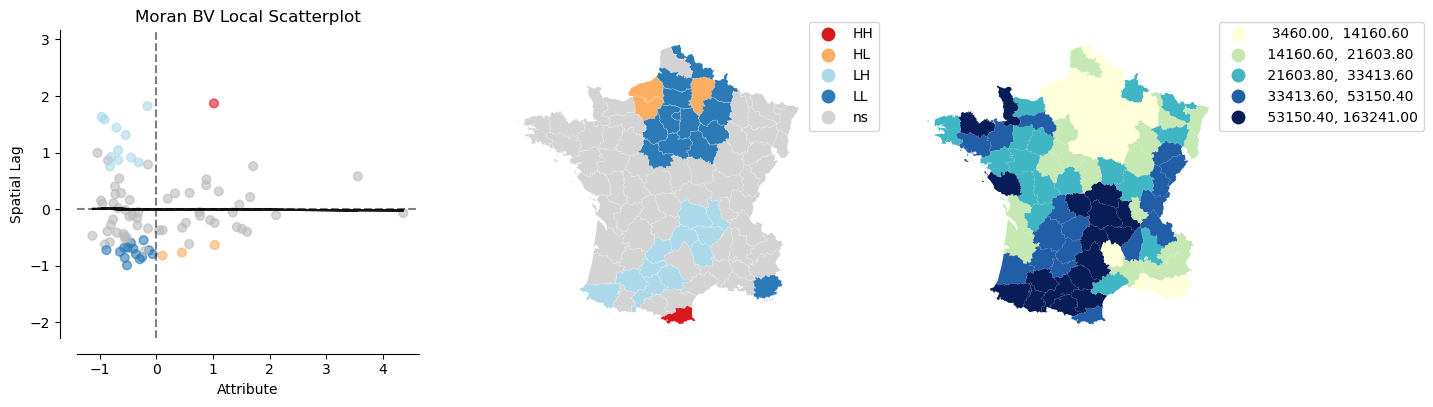

In [21]:
plot_local_autocorrelation(moran_loc_bv, gdf, 'Suicids')
plt.show()